<a href="https://colab.research.google.com/github/gachchami/qmitra/blob/main/ZNECombinations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
!pip install cirq
!pip install mitiq


CODE#2

In [88]:
import cirq

def execute (circuit, noise_level=0.05): #scale noise level from here
  """Returns Tr[rho |0><0|] where rho is state prepared by the circuit with the depolarizing noise."""

  #add depolarising noise
  noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))

  return (
      cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0,0].real

  )

  #ZNE (we will define a circuit to work with)
a,b,c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.X(c),
    cirq.CNOT(a,b),
    cirq.CNOT(b,c),
    cirq.Y(b),
    cirq.S(a)
)

print(circuit)

0: ───H───@───S───────
          │
1: ───────X───@───Y───
              │
2: ───X───────X───────


In [89]:
from mitiq.zne.scaling import fold_gates_at_random, fold_global

folded_circuit = fold_gates_at_random(circuit, scale_factor = 4) #type of foldings

print(folded_circuit)

0: ───H───H───H───H───H───@───@───@───@───@───S───S^-1───S───────────────
                          │   │   │   │   │
1: ───────────────────────X───X───X───X───X───@───@──────@───Y───Y───Y───
                                              │   │      │
2: ───X───X───X───X───X───────────────────────X───X──────X───────────────


In [90]:
#Extrapolation (compute the Zero-Noise limit)

In [91]:
from mitiq.zne.inference import RichardsonFactory, LinearFactory, ExpFactory, PolyFactory, PolyExpFactory, AdaExpFactory

factory =  RichardsonFactory([1,3,5]) #here you can change the extrapolation methods: Factory objects

factory.run(circuit, execute)
factory.reduce()

0.024460401386022738

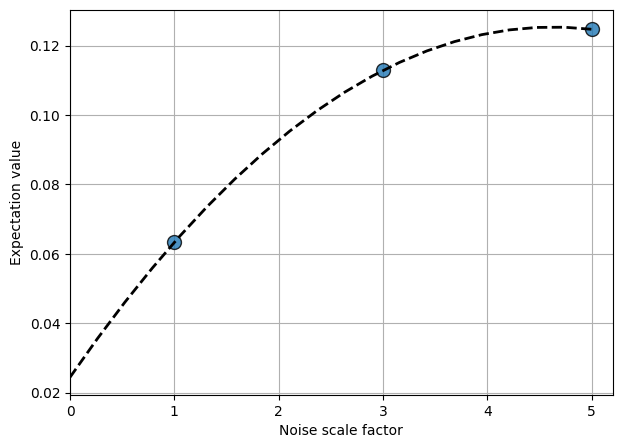

In [92]:
factory.plot_fit();

In [93]:
from mitiq import zne

true_value = execute(circuit,noise_level=0.04)
noisy_value = execute(circuit)
zne_value = zne.execute_with_zne(circuit,execute)

print(f"Error w/o Mitiq:{abs((true_value - noisy_value)/true_value):.3f}")
print(f"Error w Mitiq: {abs((true_value - zne_value)/ true_value):.3f}")

Error w/o Mitiq:0.184
Error w Mitiq: 1.073


In [94]:
"""Returns Tr[rho |0><0|] where rho is state prepared by the circuit with the depolarizing noise."""
# Add depolarizing noise
noisy_circuit = circuit.with_noise(cirq.depolarize(p=0.04))

# Create a DensityMatrixSimulator and simulate the noisy circuit
simulator = cirq.DensityMatrixSimulator()
result = simulator.simulate(noisy_circuit)

# Extract the final density matrix and compute the desired trace
density_matrix = result.final_density_matrix
trace = density_matrix[0, 0]



def some_function():
    trace = density_matrix[0,0]
    return trace

print(trace)


(0.053470325+0j)


In [95]:
print(density_matrix)

[[0.05347032+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.007719j  ]
 [0.        +0.j         0.02618846+0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.00042264j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.04387365+0.j
  0.        +0.j         0.        +0.j         0.        +0.01542643j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.37646717+0.j         0.        +0.28174362j 0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        -0.28174362j 0.37646717+0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        -0.01542643j
  0.        +0.j         0.        +0.j       

ZNE + REM (We begin by importing the relevant modules and libraries required for the rest of this tutorial.)

In [96]:
!pip install cirq
!pip install mitiq
import cirq
import numpy as np
from mitiq.benchmarks import generate_rb_circuits
from mitiq.benchmarks import generate_w_circuit
from mitiq.benchmarks import generate_mirror_circuit
from mitiq.benchmarks import generate_ghz_circuit

from mitiq import MeasurementResult, Observable, PauliString, raw

We will demonstrate using REM + ZNE on RB circuits, which are generated using Mitiq’s built-in benchmarking circuit generation function, generate_rb_circuits()

In [97]:
circuit = generate_rb_circuits(2, 10)[0]
print(circuit)

0: ───X^0──────────────@───X^-0.5───Y^-0.5───Y───────X^0────────────@───Y^-0.5───@───Y^0.5────@───X^0───────────────@───Y^0.5────@───Y────────X^0.5───X^-0.5───Y^-0.5───@───Y^0.5───X^0.5───X^-0.5───Y^-0.5───@───Y^0.5────@───Y───────X^0.5───Y^-0.5───X^0.5───Y^-0.5───@───Y^0.5────@───Y^0.5───Y───────X^0.5────────────────────────────@───X^-0.5───Y^-0.5───Y^0.5───X^0───@───Y^0.5────@───Y───────X^0.5───X^-0.5───Y^0.5───@───Y^0.5────@───Y────────X^0.5────Y^-0.5───X^0─────@───Y^-0.5───@───Y^0.5────@───Y^-0.5───X^0.5───Y^-0.5───@───X^-0.5───Y^-0.5───
                       │                                            │            │            │                     │            │                                      │                                     │            │                                             │            │                                                    │                                   │            │                                    │            │                     

The noise in this example is a combination of depolarizing and readout errors, the latter of which are modeled as bit flips immediately prior to measurement. We use an executor function to run the quantum circuit with the noise model applied.

In [98]:
def execute(circuit: cirq.Circuit, noise_level: float = 0.002, p0: float = 0.05) -> MeasurementResult:
    """Execute a circuit with depolarizing noise of strength ``noise_level`` and readout errors ...
    """
    measurements = circuit[-1]
    circuit =  circuit[:-1]
    circuit = circuit.with_noise(cirq.depolarize(noise_level))
    circuit.append(cirq.bit_flip(p0).on_each(circuit.all_qubits()))
    circuit.append(measurements)

    simulator = cirq.DensityMatrixSimulator()

    result = simulator.run(circuit, repetitions=1000)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings)

In this example, the observable of interest is ZI + IZ
. For the circuit defined above, the ideal (noiseless) expectation value of the ZI +IZ observable is 2, but as we will see, the unmitigated (noisy) result is impacted by depolarizing and readout errors.

In [99]:
obs = Observable(PauliString("ZI"), PauliString("IZ"))
noisy = raw.execute(circuit, execute, obs)

In [100]:
from functools import partial

ideal = raw.execute(circuit, partial(execute, noise_level=0, p0=0), obs)
print("Unmitigated value:", "{:.5f}".format(noisy.real))

Unmitigated value: 1.34200


In [101]:
from mitiq import rem

p0 = p1 = 0.05
icm = rem.generate_inverse_confusion_matrix(2, p0, p1)
rem_executor = rem.mitigate_executor(execute, inverse_confusion_matrix=icm)

rem_result = obs.expectation(circuit, rem_executor)
print("Mitigated value obtained with REM:", "{:.5f}".format(rem_result.real))

Mitigated value obtained with REM: 1.39800


In [102]:
from mitiq import zne

zne_executor = zne.mitigate_executor(execute, observable=obs, scale_noise=zne.scaling.folding.fold_global)
zne_result = zne_executor(circuit)
print("Mitigated value obtained with ZNE:", "{:.5f}".format(zne_result.real))

Mitigated value obtained with ZNE: 2.04400


In [103]:
combined_executor = zne.mitigate_executor(rem_executor, observable=obs, scale_noise=zne.scaling.folding.fold_global)

combined_result = combined_executor(circuit)
print("Mitigated value obtained with REM + ZNE:", "{:.5f}".format(combined_result.real))

Mitigated value obtained with REM + ZNE: 2.31400


In [104]:
#circuit = generate_ghz_circuit(2, 10)[0]
#circuit = generate_mirror_circuit(2, 10)[0]
#circuit = generate_w_circuit(2, 10)[0]

In [105]:

from cirq import LineQubit, Circuit, rx, rz, CNOT
from cirq.contrib.svg import SVGCircuit


from mitiq.benchmarks import generate_ghz_circuit
# Generate a rb circuit with 3 qubits
circuit = generate_rb_circuits(2, 10)[0]
print(circuit)
#Define noise parameters (replace these with your actual noise parameters)
noise_model = {
    cirq.H: 0.01,
    cirq.CNOT: 0.02,
    cirq.Rz: 0.005
}




0: ───Y^-0.5───X^0.5───@───X^0───Y^0.5───X^-0.5───────────────────@───X^0──────Y────────X^-0.5───────────@───Y^0.5────@───X^-0.5───Y^-0.5───X^0.5───X^0.5───Y^-0.5───@───Y^0.5────@───Y^0.5───X^-0.5───Y^0.5───@───Y^0.5────@───Y^0.5───Y────────X^0.5───────────@───X^0───X───────Y^-0.5─────────@───X^0──────Y^-0.5───X^-0.5─────────────────@───Y^0.5────X^0.5────X^0.5───Y^0───────────────────────@───Y^0.5────X^0.5────Y^0.5───X^-0.5─────────@───X^0───X───────Y^0───────────@───Y^0.5────@───X^-0.5───Y^-0.5───X^0.5───
                       │                                          │                                      │            │                                              │            │                            │            │                                    │                                │                                            │                                                       │                                            │                               │            │
1: ──

In [108]:
#  Zero-Noise Extrapolation (ZNE) technique to mitigate noise

def execute(circuit: cirq.Circuit, noise_level: float = 0.002, p0: float = 0.05) -> MeasurementResult:
    """Execute a circuit with depolarizing noise of strength ``noise_level`` and readout errors ...
    """

    measurements = circuit[-1]

    circuit_1 =  circuit[:-1]
    circuit_1 = circuit_1.with_noise(cirq.depolarize(noise_level))
    circuit_1.append(cirq.bit_flip(p0).on_each(circuit_1.all_qubits()))
    circuit_1.append(measurements)

    simulator = cirq.DensityMatrixSimulator()

    result = simulator.run(circuit_1, repetitions=10000)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings)

print(circuit[-1],"circuitt")

from mitiq.zne import execute_with_zne
richardson_factory = zne.inference.RichardsonFactory(scale_factors=[1, 2, 3])
zne_value = execute_with_zne(circuit,execute,scale_noise = fold_global , factory = richardson_factory )
#Apply Dynamical Decoupling (DD) technique to further mitigate noise

# from mitiq import ddd

# rule = ddd.rules.yy
# dd_ghz_circuit = ddd.execute_with_ddd(
#     circuit=circuit,
#     executor=execute,
#     rule=rule,
# )



  ╷ 0
╶─┼───────
0 │ X^0.5
  │ circuitt


ValueError: Circuit has no measurements to sample.